<a href="https://colab.research.google.com/github/inesNeji/Date-palm-varieties-classification-/blob/main/notebook5b9a00b3e3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wadhasnalhamdan_date_fruit_image_dataset_in_controlled_environment_path = kagglehub.dataset_download('wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment')

print('Data source import complete.')


100%|██████████| 3.11G/3.11G [01:26<00:00, 38.8MB/s]

Extracting files...


Data source import complete.


# DATE FRUIT

* DATE FRUIT classification with CNN

### IMPORTS

In [ ]:
# pip install opencv-python

In [ ]:
# !pip install scikit-learn

In [ ]:
# !pip install --upgrade tensorflow

In [2]:
import os
import random
import warnings

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from IPython.display import Image

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Reshape, GlobalAveragePooling2D
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

### READING DATA

In [13]:
!pip install mlcroissant

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 28.0 MB/s eta 0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15127 sha256=2b24df13c8d221e303642e2ad9e1fc56e69c719dad752fcc1a0dd748b84949ba
  Stored in directory: /root/.cache/pip/wheels/53/cf/51/a4ea10224b7fdb523e18e2033cadf2a8657517d1f95f3f5413
Successfully built jsonpath-rw


In [31]:
import os
import json

# Copy your kaggle.json content here
kaggle_token = {
  "username": "nejiines",
  "key": "05459af1fff6fc710cb3b2f65b98c5fa"
}

# Save the token
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_token, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [32]:
#!/bin/bash
!kaggle datasets download wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment

Dataset URL: https://www.kaggle.com/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment
License(s): Attribution 4.0 International (CC BY 4.0)


In [35]:
!mkdir -p ./data/lgg
!unzip -q /content/date-fruit-image-dataset-in-controlled-environment.zip -d ./data/lgg


In [36]:
base_dir = '/content/data/lgg'

In [37]:
data = []
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, img_file)
            data.append([file_path, class_name])

### CREATING DATAFRAME

In [38]:
df = pd.DataFrame(data, columns=['img', 'label'])

print(df.head())

                                                img    label
0  /content/data/lgg/Meneifi/Meneifi Date (118).JPG  Meneifi
1  /content/data/lgg/Meneifi/Meneifi Date (186).JPG  Meneifi
2  /content/data/lgg/Meneifi/Meneifi Date (201).JPG  Meneifi
3  /content/data/lgg/Meneifi/Meneifi Date (216).JPG  Meneifi
4  /content/data/lgg/Meneifi/Meneifi Date (174).JPG  Meneifi


In [39]:
df.shape

(1658, 2)

In [40]:
df.groupby('label', as_index=False).count()

,label,img
0,Ajwa,175
1,Galaxy,190
2,Medjool,135
3,Meneifi,232
4,Nabtat Ali,177
5,Rutab,146
6,Shaishe,171
7,Sokari,264
8,Sugaey,168


In [41]:
labels = df.label.unique()
print(labels , '-- len:',len(labels))

['Meneifi' 'Galaxy' 'Nabtat Ali' 'Sugaey' 'Rutab' 'Medjool' 'Sokari'
 'Shaishe' 'Ajwa'] -- len: 9


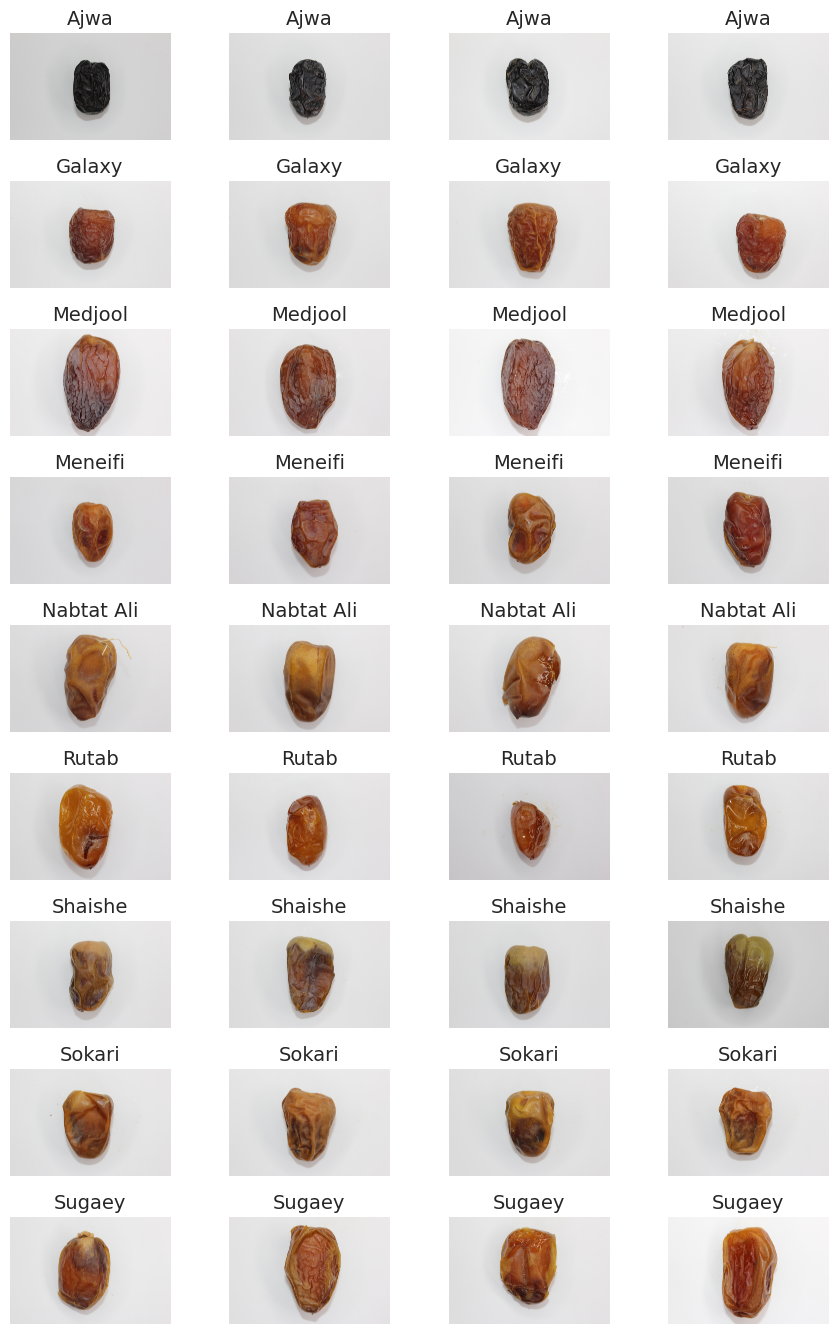

In [42]:
selected_images = df.groupby('label', as_index=False).apply(lambda x: x.sample(n=4, random_state=1)).reset_index(drop=True)

sns.set(style='whitegrid')
fig, axes = plt.subplots(len(labels), 4, figsize=(9, len(labels)*1.5))

axes = axes.flatten()

for ax, (img_path, label) in zip(axes, zip(selected_images['img'], selected_images['label'])):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label, fontsize=14)

plt.tight_layout()
plt.show()

### PREPARING TEST DATA

In [43]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
test_df, validation_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])

train_df.shape, validation_df.shape, test_df.shape

((1326, 2), (166, 2), (166, 2))

In [44]:
batch_size = 64
image_size = (224, 224)
input_shape = (224, 224, 3)

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img',
    y_col='label',
    color_mode = 'rgb',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

validation_data = datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='img',
    y_col='label',
    color_mode = 'rgb',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='img',
    y_col='label',
    color_mode = 'rgb',
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 1326 validated image filenames belonging to 9 classes.
Found 166 validated image filenames belonging to 9 classes.
Found 166 validated image filenames belonging to 9 classes.


In [45]:
print("Class Indices:", train_data.class_indices)

Class Indices: {'Ajwa': 0, 'Galaxy': 1, 'Medjool': 2, 'Meneifi': 3, 'Nabtat Ali': 4, 'Rutab': 5, 'Shaishe': 6, 'Sokari': 7, 'Sugaey': 8}


### CNN

In [46]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_data, epochs=15, validation_data= validation_data, verbose=0, callbacks=[early_stopping])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,108,297 (19.49 MB)

 Trainable params: 5,108,297 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.0781 - loss: 2.2058

KeyboardInterrupt: 

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

In [ ]:
ax = history_df[['accuracy','val_accuracy']].plot(title = "Train and Validation Accuracies" , marker='o')
ax.set(xlabel ="Epochs", ylabel = "Accuracy")
plt.show()

In [ ]:
test_label = test_data.classes
prediction = model.predict(test_data)
prediction = np.argmax(prediction, axis=1)

In [ ]:
class_labels = list(test_data.class_indices.keys())


test_images, _ = next(test_data)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()


for i in range(16):
    axes[i].imshow(test_images[i])

    actual_label = class_labels[test_label[i]]
    predicted_label = class_labels[prediction[i]]

    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)

    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
cm1 = confusion_matrix(test_label, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=60)
plt.grid(False)
plt.show()

In [ ]:
class_labels = list(test_data.class_indices.keys())
report = classification_report(test_label, prediction, target_names=class_labels)
print(report)

In [ ]:
model.save('date_fruit.keras')